In [1]:
import sys
sys.path.append('eucalc_directory')
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from numpy import genfromtxt
from sklearn.decomposition import PCA

# Path to the folder containing the CSV files
datafolder = "Old_Young_Comparison"

all_files = os.listdir(datafolder)

# Get all CSV filenames in the folder
names = [file for file in all_files if file.lower().endswith(('.tif', '.tiff'))]


# Split names into K8 and K14 groups
names_k8 = [nm for nm in names if 'K8' in nm]
names_k14 = [nm for nm in names if 'K14' in nm]

In [4]:
from PIL import Image
import skfmm
# Load the sample TIFF image
file_path = os.path.join(datafolder, 'Y2_K14._8.tif')
img = Image.open(file_path).convert('L')
img_array = np.array(img)

# Create a binary image by thresholding (pixels < 128 become 1, else 0)
binary = (img_array < 128).astype(float)

# Shift the binary image so that the zero level corresponds to the boundary
phi = binary - 0.5

# Compute the signed distance function using skfmm
distance_map = skfmm.distance(phi)

# Plot the original image and its signed distance function filtration side-by-side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(img, cmap='gray')
axs[0].set_title('Sample TIFF Image')
axs[0].axis('off')

im = axs[1].imshow(distance_map, cmap='jet', origin='lower')
axs[1].set_title('Signed Distance Function Filtration')
axs[1].axis('off')
plt.colorbar(im, ax=axs[1])

plt.tight_layout()
plt.show()

ModuleNotFoundError: No module named 'skfmm'

In [8]:
import os
import numpy as np
from PIL import Image
from gudhi import CubicalComplex

def extract_group(name):
    return name.split('_')[0]

def compute_betti_by_group(names, datafolder):
    """
    Compute the average first Betti number for each group within the names list.

    Parameters:
        names (list of str): List of image filenames.
        datafolder (str): Path to the folder containing the images.

    Returns:
        dict: A dictionary with group names as keys and average Betti-1 as values.
    """
    # Group filenames by their group info
    grouped_files = {}
    for nm in names:
        group = extract_group(nm)
        if group not in grouped_files:
            grouped_files[group] = []
        grouped_files[group].append(nm)

    # Compute average Betti-1 for each group
    group_betti_averages = {}
    for group, files in grouped_files.items():
        betti_numbers = []

        for nm in files:
            # Load image and create a binary matrix
            file_path = os.path.join(datafolder, nm)
            binary_array = (np.array(Image.open(file_path).convert('L')) < 128).astype(int)  # True (white) as 0, False (black) as 1

            # Build cubical complex
            cplx = CubicalComplex(top_dimensional_cells=binary_array)
            cplx.persistence()

            # Extract Betti-1 (number of loops)
            betti_1 = sum(1 for dim, _ in cplx.persistence_intervals_in_dimension(1))
            betti_numbers.append(betti_1)

        # Compute average Betti-1 for the group
        group_betti_averages[group] = np.mean(betti_numbers) if betti_numbers else 0

    return group_betti_averages

# Path to the folder containing the images
datafolder = "Old_Young_Comparison"

# Get all TIFF filenames in the folder
all_files = os.listdir(datafolder)
names = [file for file in all_files if file.lower().endswith(('.tif', '.tiff'))]

# Split names into K8 and K14 groups
names_k8 = [nm for nm in names if 'K8' in nm]
names_k14 = [nm for nm in names if 'K14' in nm]

# Compute average Betti-1 for each group in names_k8
betti_averages_k8 = compute_betti_by_group(names_k8, datafolder)
print("Average Betti-1 for K8 groups:", betti_averages_k8)

# Compute average Betti-1 for each group in names_k14
betti_averages_k14 = compute_betti_by_group(names_k14, datafolder)
print("Average Betti-1 for K14 groups:", betti_averages_k14)


Average Betti-1 for K8 groups: {'O3': np.float64(27.4), 'O5': np.float64(18.3), 'O4': np.float64(15.7), 'O2': np.float64(26.3), 'Y2': np.float64(18.4), 'Y1': np.float64(40.6), 'O1': np.float64(24.4)}
Average Betti-1 for K14 groups: {'Y1': np.float64(5.1), 'O5': np.float64(7.0), 'O3': np.float64(8.2), 'O2': np.float64(4.4), 'O1': np.float64(12.4), 'Y2': np.float64(3.4), 'O4': np.float64(6.5)}


In [45]:
import os
import numpy as np
from PIL import Image
from gudhi import CubicalComplex
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def extract_group(name):
    return name[0]

def compute_betti_by_group(names, datafolder):
    """
    Compute the average 0th and 1st Betti numbers for each group within the names list.
    
    Parameters:
        names (list of str): List of image filenames.
        datafolder (str): Path to the folder containing the images.
    
    Returns:
        dict: A dictionary with group names as keys and a tuple of average Betti-0 and Betti-1 as values.
    """
    # Group filenames by their group info
    grouped_files = {}
    betti_coords = {}
    for nm in names:
        group = extract_group(nm)
        if group not in grouped_files:
            grouped_files[group] = []
        grouped_files[group].append(nm)
        betti_coords[nm] = []

    # Compute average Betti-0 and Betti-1 for each group
    group_betti_averages = {}
    for group, files in grouped_files.items():
        betti_0_numbers = []
        betti_1_numbers = []

        for nm in files:
            # Load image and create a binary matrix
            file_path = os.path.join(datafolder, nm)
            binary_array = (np.array(Image.open(file_path).convert('L')) < 128).astype(int)

            # Build cubical complex
            cplx = CubicalComplex(top_dimensional_cells=binary_array)
            cplx.persistence()

            # Extract Betti-0 (number of connected components)
            betti_0 = sum(1 for dim, _ in cplx.persistence_intervals_in_dimension(0))
            betti_0_numbers.append(betti_0)

            # Extract Betti-1 (number of loops)
            betti_1 = sum(1 for dim, _ in cplx.persistence_intervals_in_dimension(1))
            betti_1_numbers.append(betti_1)
            betti_coords[nm] = [betti_0, betti_1]

        # Compute average Betti-0 and Betti-1 for the group
        avg_betti_0 = np.mean(betti_0_numbers) if betti_0_numbers else 0
        avg_betti_1 = np.mean(betti_1_numbers) if betti_1_numbers else 0

        group_betti_averages[group] = (avg_betti_0, avg_betti_1)

    return group_betti_averages, betti_coords

# Path to the folder containing the images
datafolder = "Old_Young_Comparison"

# Get all TIFF filenames in the folder
all_files = os.listdir(datafolder)
names = [file for file in all_files if file.lower().endswith(('.tif', '.tiff'))]

# Split names into K8 and K14 groups
names_k8 = [nm for nm in names if 'K8' in nm]
names_k14 = [nm for nm in names if 'K14' in nm]

# --- Plot for K8 groups ---
betti_averages_k8, k8_coords = compute_betti_by_group(names_k8, datafolder)
print("Average Betti-0 and Betti-1 for K8 groups:", betti_averages_k8)

# --- Plot for K14 groups ---
betti_averages_k14, k14_coords = compute_betti_by_group(names_k14, datafolder)
print("Average Betti-0 and Betti-1 for K14 groups:", betti_averages_k14)



Average Betti-0 and Betti-1 for K8 groups: {'O': (11.06, 22.42), 'Y': (10.6, 29.5)}
Average Betti-0 and Betti-1 for K14 groups: {'Y': (27.8, 4.25), 'O': (25.02, 7.7)}


Average Betti numbers for K8 (filtered, Y2): {'O': (np.float64(11.06), np.float64(22.42)), 'Y': (np.float64(13.1), np.float64(18.4))}
Average Betti numbers for K14: {'Y': (np.float64(27.8), np.float64(4.25)), 'O': (np.float64(25.02), np.float64(7.7))}


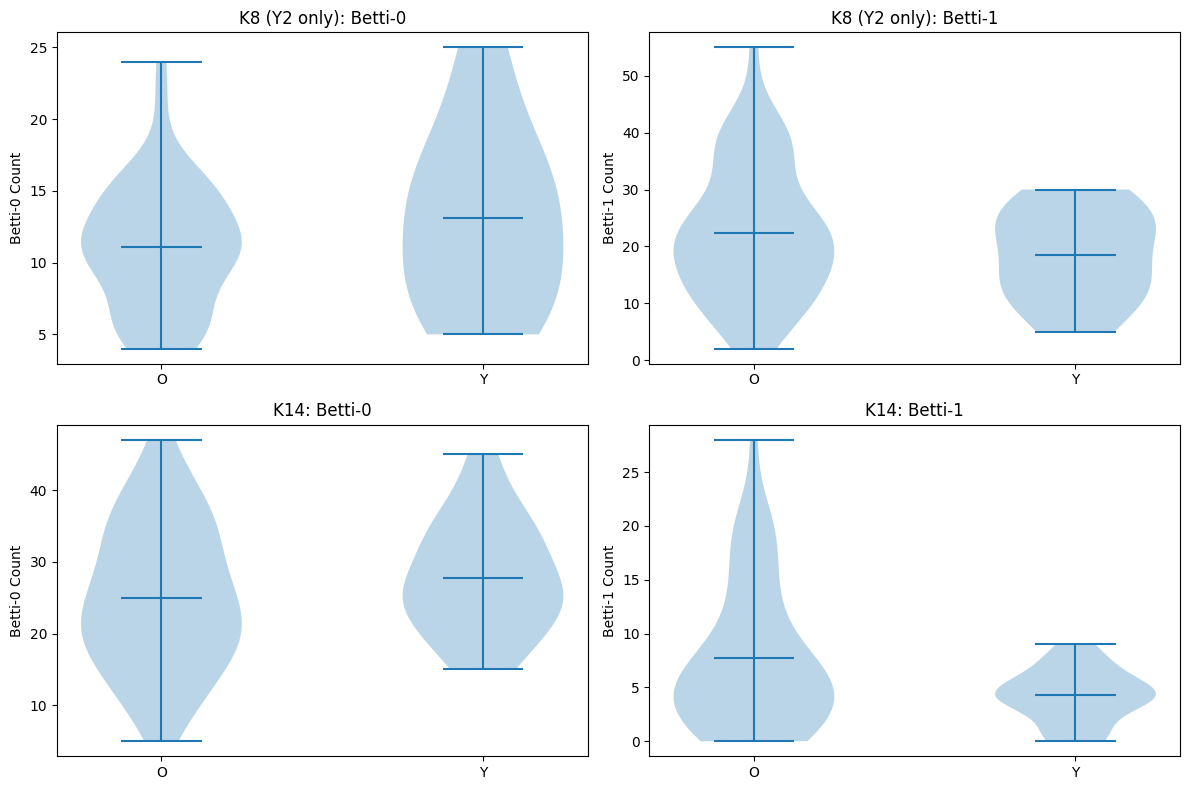

In [7]:
import os
import numpy as np
from PIL import Image
from gudhi import CubicalComplex
import matplotlib.pyplot as plt

def extract_group(name):
    # For grouping, here we still use the first character.
    return name[0]

def compute_betti_by_group(names, datafolder):
    """
    Compute the 0th and 1st Betti numbers for each image,
    grouping by the first character of the filename.
    """
    grouped_files = {}
    betti_coords = {}
    for nm in names:
        group = extract_group(nm)
        if group not in grouped_files:
            grouped_files[group] = []
        grouped_files[group].append(nm)
        betti_coords[nm] = []
    
    group_betti_averages = {}
    for group, files in grouped_files.items():
        betti_0_numbers = []
        betti_1_numbers = []
        for nm in files:
            file_path = os.path.join(datafolder, nm)
            binary_array = (np.array(Image.open(file_path).convert('L')) < 128).astype(int)
            cplx = CubicalComplex(top_dimensional_cells=binary_array)
            cplx.persistence()
            betti_0 = sum(1 for dim, _ in cplx.persistence_intervals_in_dimension(0))
            betti_1 = sum(1 for dim, _ in cplx.persistence_intervals_in_dimension(1))
            betti_0_numbers.append(betti_0)
            betti_1_numbers.append(betti_1)
            betti_coords[nm] = [betti_0, betti_1]
        avg_betti_0 = np.mean(betti_0_numbers) if betti_0_numbers else 0
        avg_betti_1 = np.mean(betti_1_numbers) if betti_1_numbers else 0
        group_betti_averages[group] = (avg_betti_0, avg_betti_1)
    
    return group_betti_averages, betti_coords

def group_betti_data(betti_coords):
    """
    Reorganize the betti_coords dictionary by group label.
    """
    grouped = {}
    for nm, betti in betti_coords.items():
        group = extract_group(nm)
        if group not in grouped:
            grouped[group] = {"betti_0": [], "betti_1": []}
        grouped[group]["betti_0"].append(betti[0])
        grouped[group]["betti_1"].append(betti[1])
    return grouped

def filter_dataset(dataset, lower_pct, upper_pct):
    """
    Return the subset of dataset values that lie between the lower_pct and upper_pct percentiles.
    """
    dataset = np.array(dataset)
    lower = np.percentile(dataset, lower_pct)
    upper = np.percentile(dataset, upper_pct)
    return dataset[(dataset >= lower) & (dataset <= upper)]

# Path to the folder containing the images
datafolder = "Old_Young_Comparison"
all_files = os.listdir(datafolder)
names = [file for file in all_files if file.lower().endswith(('.tif', '.tiff'))]

# For the K8 group, only consider files whose names start with "Y2"
names_k8 = [nm for nm in names if 'K8' in nm and (nm.startswith('Y2') or nm.startswith('O'))]

# For K14, keep as before
names_k14 = [nm for nm in names if 'K14' in nm]

# Compute Betti numbers for both groups
betti_averages_k8, k8_coords = compute_betti_by_group(names_k8, datafolder)
betti_averages_k14, k14_coords = compute_betti_by_group(names_k14, datafolder)

print("Average Betti numbers for K8 (filtered, Y2):", betti_averages_k8)
print("Average Betti numbers for K14:", betti_averages_k14)

# Regroup the Betti numbers by group label (using the first character)
grouped_k8 = group_betti_data(k8_coords)
grouped_k14 = group_betti_data(k14_coords)

# Order group labels for plotting
groups_k8 = sorted(grouped_k8.keys())
groups_k14 = sorted(grouped_k14.keys())

# Prepare data arrays for each group and Betti degree
data_k8_betti0 = [grouped_k8[g]["betti_0"] for g in groups_k8]
data_k8_betti1 = [grouped_k8[g]["betti_1"] for g in groups_k8]
data_k14_betti0 = [grouped_k14[g]["betti_0"] for g in groups_k14]
data_k14_betti1 = [grouped_k14[g]["betti_1"] for g in groups_k14]

# Define the percentile range to which you want to restrict the density estimation.
percentile_range = (0, 100)  # Only consider values between the 10th and 90th percentiles

# Filter each dataset to only include values within the selected percentile range
filtered_k8_betti0 = [filter_dataset(d, *percentile_range) for d in data_k8_betti0]
filtered_k8_betti1 = [filter_dataset(d, *percentile_range) for d in data_k8_betti1]
filtered_k14_betti0 = [filter_dataset(d, *percentile_range) for d in data_k14_betti0]
filtered_k14_betti1 = [filter_dataset(d, *percentile_range) for d in data_k14_betti1]

# Create a 2x2 plot:
# Top row: K8 group (only Y2 files) for Betti-0 and Betti-1.
# Bottom row: K14 group for Betti-0 and Betti-1.
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# K8 Betti-0 violin plot using filtered data
axs[0, 0].violinplot(filtered_k8_betti0, showmeans=True)
axs[0, 0].set_title('K8 (Y2 only): Betti-0')
axs[0, 0].set_xticks(np.arange(1, len(groups_k8)+1))
axs[0, 0].set_xticklabels(groups_k8)
axs[0, 0].set_ylabel('Betti-0 Count')

# K8 Betti-1 violin plot using filtered data
axs[0, 1].violinplot(filtered_k8_betti1, showmeans=True)
axs[0, 1].set_title('K8 (Y2 only): Betti-1')
axs[0, 1].set_xticks(np.arange(1, len(groups_k8)+1))
axs[0, 1].set_xticklabels(groups_k8)
axs[0, 1].set_ylabel('Betti-1 Count')

# K14 Betti-0 violin plot using filtered data
axs[1, 0].violinplot(filtered_k14_betti0, showmeans=True)
axs[1, 0].set_title('K14: Betti-0')
axs[1, 0].set_xticks(np.arange(1, len(groups_k14)+1))
axs[1, 0].set_xticklabels(groups_k14)
axs[1, 0].set_ylabel('Betti-0 Count')

# K14 Betti-1 violin plot using filtered data
axs[1, 1].violinplot(filtered_k14_betti1, showmeans=True)
axs[1, 1].set_title('K14: Betti-1')
axs[1, 1].set_xticks(np.arange(1, len(groups_k14)+1))
axs[1, 1].set_xticklabels(groups_k14)
axs[1, 1].set_ylabel('Betti-1 Count')

plt.tight_layout()
plt.show()


Average Betti numbers for K8 (filtered, Y2): {'Y': (19.2, 16.875), 'O': (18.04, 15.06)}
Average Betti numbers for K14: {'Y': (27.8, 4.25), 'O': (25.02, 7.7)}


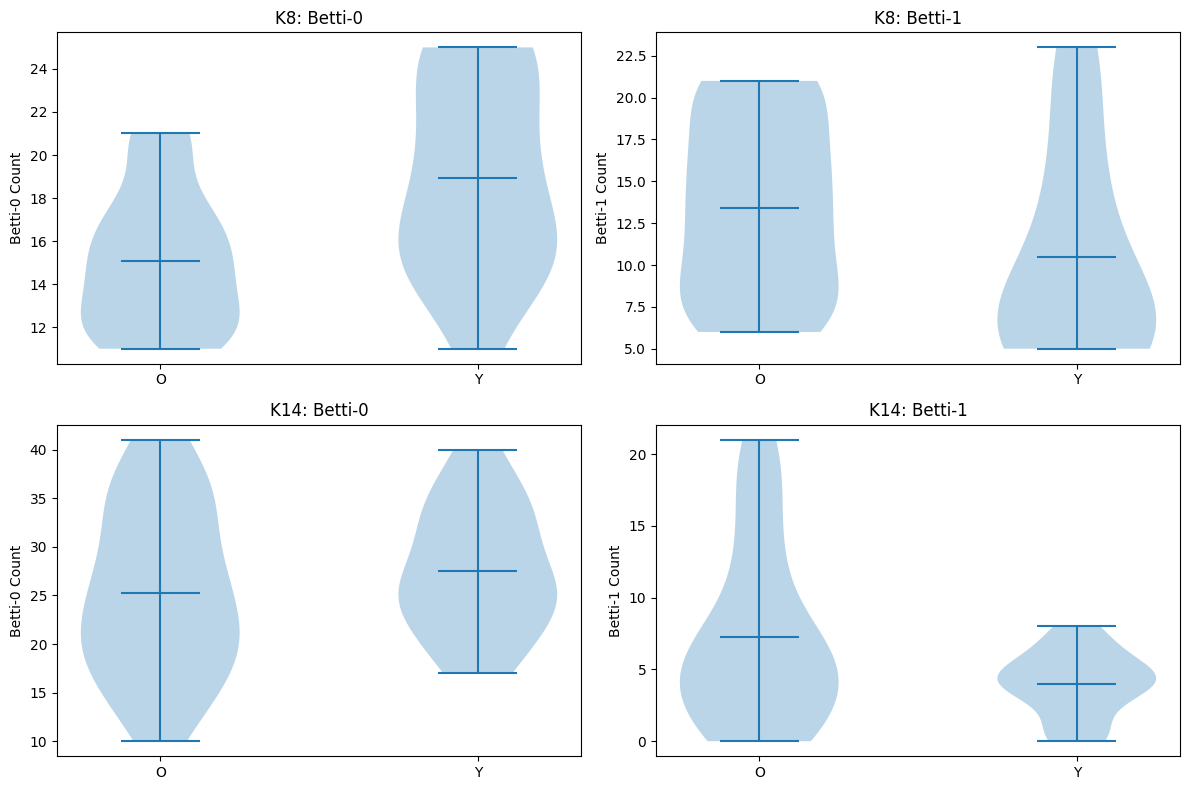

In [71]:
import os
import numpy as np
from PIL import Image
from gudhi import CubicalComplex
import matplotlib.pyplot as plt

def extract_group(name):
    # For grouping, here we still use the first character.
    return name[0]

def compute_betti_by_group(names, datafolder):
    """
    Compute the 0th and 1st Betti numbers for each image,
    grouping by the first character of the filename.
    """
    grouped_files = {}
    betti_coords = {}
    for nm in names:
        group = extract_group(nm)
        if group not in grouped_files:
            grouped_files[group] = []
        grouped_files[group].append(nm)
        betti_coords[nm] = []
    
    group_betti_averages = {}
    for group, files in grouped_files.items():
        betti_0_numbers = []
        betti_1_numbers = []
        for nm in files:
            file_path = os.path.join(datafolder, nm)
            binary_array = (np.array(Image.open(file_path).convert('L')) < 128).astype(int)
            cplx = CubicalComplex(top_dimensional_cells=binary_array)
            cplx.persistence()
            betti_0 = sum(1 for dim, _ in cplx.persistence_intervals_in_dimension(0))
            betti_1 = sum(1 for dim, _ in cplx.persistence_intervals_in_dimension(1))
            betti_0_numbers.append(betti_0)
            betti_1_numbers.append(betti_1)
            betti_coords[nm] = [betti_0, betti_1]
        avg_betti_0 = np.mean(betti_0_numbers) if betti_0_numbers else 0
        avg_betti_1 = np.mean(betti_1_numbers) if betti_1_numbers else 0
        group_betti_averages[group] = (avg_betti_0, avg_betti_1)
    
    return group_betti_averages, betti_coords

def group_betti_data(betti_coords):
    """
    Reorganize the betti_coords dictionary by group label.
    """
    grouped = {}
    for nm, betti in betti_coords.items():
        group = extract_group(nm)
        if group not in grouped:
            grouped[group] = {"betti_0": [], "betti_1": []}
        grouped[group]["betti_0"].append(betti[0])
        grouped[group]["betti_1"].append(betti[1])
    return grouped

def filter_dataset(dataset, lower_pct, upper_pct):
    """
    Return the subset of dataset values that lie between the lower_pct and upper_pct percentiles.
    """
    dataset = np.array(dataset)
    lower = np.percentile(dataset, lower_pct)
    upper = np.percentile(dataset, upper_pct)
    return dataset[(dataset >= lower) & (dataset <= upper)]

# Path to the folder containing the images
datafolder = "Old_Young_Comparison"
all_files = os.listdir(datafolder)
names = [file for file in all_files if file.lower().endswith(('.tif', '.tiff'))]

# For the K8 group, only consider files whose names start with "Y2"
names_k8 = [nm for nm in names if 'K8' ]

# For K14, keep as before
names_k14 = [nm for nm in names if 'K14' in nm]

# Compute Betti numbers for both groups
betti_averages_k8, k8_coords = compute_betti_by_group(names_k8, datafolder)
betti_averages_k14, k14_coords = compute_betti_by_group(names_k14, datafolder)

print("Average Betti numbers for K8 (filtered, Y2):", betti_averages_k8)
print("Average Betti numbers for K14:", betti_averages_k14)

# Regroup the Betti numbers by group label (using the first character)
grouped_k8 = group_betti_data(k8_coords)
grouped_k14 = group_betti_data(k14_coords)

# Order group labels for plotting
groups_k8 = sorted(grouped_k8.keys())
groups_k14 = sorted(grouped_k14.keys())

# Prepare data arrays for each group and Betti degree
data_k8_betti0 = [grouped_k8[g]["betti_0"] for g in groups_k8]
data_k8_betti1 = [grouped_k8[g]["betti_1"] for g in groups_k8]
data_k14_betti0 = [grouped_k14[g]["betti_0"] for g in groups_k14]
data_k14_betti1 = [grouped_k14[g]["betti_1"] for g in groups_k14]

# Define the percentile range to which you want to restrict the density estimation.
percentile_range = (30, 70)  # Only consider values between the 10th and 90th percentiles
percentile_range2 = (5,95)

# Filter each dataset to only include values within the selected percentile range
filtered_k8_betti0 = [filter_dataset(d, *percentile_range) for d in data_k8_betti0]
filtered_k8_betti1 = [filter_dataset(d, *percentile_range) for d in data_k8_betti1]
filtered_k14_betti0 = [filter_dataset(d, *percentile_range2) for d in data_k14_betti0]
filtered_k14_betti1 = [filter_dataset(d, *percentile_range2) for d in data_k14_betti1]

# Create a 2x2 plot:
# Top row: K8 group (only Y2 files) for Betti-0 and Betti-1.
# Bottom row: K14 group for Betti-0 and Betti-1.
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# K8 Betti-0 violin plot using filtered data
axs[0, 0].violinplot(filtered_k8_betti0, showmeans=True)
axs[0, 0].set_title('K8: Betti-0')
axs[0, 0].set_xticks(np.arange(1, len(groups_k8)+1))
axs[0, 0].set_xticklabels(groups_k8)
axs[0, 0].set_ylabel('Betti-0 Count')

# K8 Betti-1 violin plot using filtered data
axs[0, 1].violinplot(filtered_k8_betti1, showmeans=True)
axs[0, 1].set_title('K8: Betti-1')
axs[0, 1].set_xticks(np.arange(1, len(groups_k8)+1))
axs[0, 1].set_xticklabels(groups_k8)
axs[0, 1].set_ylabel('Betti-1 Count')

# K14 Betti-0 violin plot using filtered data
axs[1, 0].violinplot(filtered_k14_betti0, showmeans=True)
axs[1, 0].set_title('K14: Betti-0')
axs[1, 0].set_xticks(np.arange(1, len(groups_k14)+1))
axs[1, 0].set_xticklabels(groups_k14)
axs[1, 0].set_ylabel('Betti-0 Count')

# K14 Betti-1 violin plot using filtered data
axs[1, 1].violinplot(filtered_k14_betti1, showmeans=True)
axs[1, 1].set_title('K14: Betti-1')
axs[1, 1].set_xticks(np.arange(1, len(groups_k14)+1))
axs[1, 1].set_xticklabels(groups_k14)
axs[1, 1].set_ylabel('Betti-1 Count')

plt.tight_layout()
plt.show()


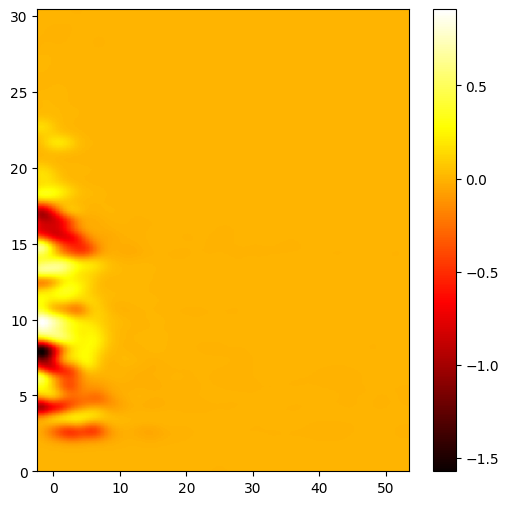

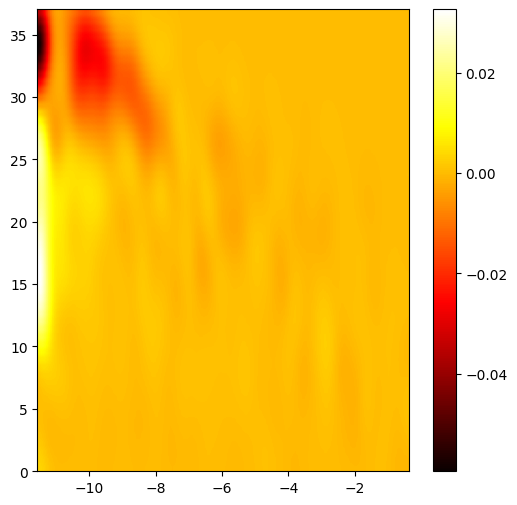

In [80]:
import os
import numpy as np
from PIL import Image
import skfmm
import matplotlib.pyplot as plt
from gudhi import CubicalComplex
from persim import PersistenceImager
from sklearn.preprocessing import MinMaxScaler
from persim.images_weights import linear_ramp

def extract_group(name):
    return name[0]

def compute_global_ranges(diagrams):
    """Compute global birth and persistence ranges for all diagrams."""
    births = []
    persistences = []
    for dgm in diagrams:
        if len(dgm) > 0:
            births.extend(dgm[:, 0])  # all birth times
            persistences.extend(dgm[:, 1] - dgm[:, 0])  # persistence values
    birth_range = (min(births), max(births)) if births else (0, 1)
    persistence_range = (min(persistences), max(persistences)) if persistences else (0, 1)
    return birth_range, persistence_range

def scale_diagram(diagram, birth_range, pers_range):
    """
    Scale persistence diagram to a consistent birth and persistence range.
    """
    if len(diagram) == 0:
        return diagram
    births = diagram[:, 0]
    deaths = diagram[:, 1]
    persistences = deaths - births
    scaler_birth = MinMaxScaler(feature_range=birth_range)
    scaler_pers = MinMaxScaler(feature_range=pers_range)
    scaled_births = scaler_birth.fit_transform(births.reshape(-1, 1)).flatten()
    scaled_persistences = scaler_pers.fit_transform(persistences.reshape(-1, 1)).flatten()
    scaled_diagram = np.column_stack([scaled_births, scaled_births + scaled_persistences])
    return scaled_diagram

def compute_betti_by_group_with_gudhi(names, datafolder,
                                      betti_percentile_range_dim0=(0,100),
                                      betti_percentile_range_dim1=(0,100)):
    """
    For each file, compute the persistence diagram(s) using Gudhi on a distance map.
    Then, using PersistenceImager, compute a persistence image for each sample.
    
    Instead of averaging over all samples per group, we first compute the Betti number (the
    number of intervals in the diagram) for each sample. Then, per group (e.g. old 'O' and young 'Y'),
    we compute the percentile thresholds for the Betti numbers and only average the persistence images
    for those samples whose Betti number falls within the specified percentile range.
    
    Returns:
        group_results (dict): For each group letter, a tuple
          (avg_persistence_image_dim0, avg_persistence_image_dim1,
           birth_range_dim0, pers_range_dim0, birth_range_dim1, pers_range_dim1)
    """
    # Group filenames by group label.
    grouped_files = {}
    for nm in names:
        grp = extract_group(nm)
        if grp not in grouped_files:
            grouped_files[grp] = []
        grouped_files[grp].append(nm)
    
    # First pass: collect all diagrams to set global ranges.
    all_diagrams_0 = []
    all_diagrams_1 = []
    for group, files in grouped_files.items():
        for nm in files:
            file_path = os.path.join(datafolder, nm)
            binary_array = (np.array(Image.open(file_path).convert('L')) < 128).astype(int)
            phi = binary_array.astype(float) - 0.5
            distance_map = skfmm.distance(phi)
            cplx = CubicalComplex(top_dimensional_cells=distance_map)
            cplx.persistence()
            diagrams_0 = cplx.persistence_intervals_in_dimension(0)
            diagrams_1 = cplx.persistence_intervals_in_dimension(1)
            # Remove infinite deaths
            if len(diagrams_0) > 0:
                diagrams_0 = diagrams_0[~np.isinf(diagrams_0[:, 1])]
                all_diagrams_0.append(diagrams_0)
            if len(diagrams_1) > 0:
                diagrams_1 = diagrams_1[~np.isinf(diagrams_1[:, 1])]
                all_diagrams_1.append(diagrams_1)
    birth_range, pers_range = compute_global_ranges(all_diagrams_0)
    birth_range_1, pers_range_1 = compute_global_ranges(all_diagrams_1)
    
    # Prepare group results: for each group, we will store tuples:
    # For dimension 0: list of (persistence_image, betti0)
    # For dimension 1: list of (persistence_image, betti1)
    group_results = {}
    for group, files in grouped_files.items():
        samples_dim0 = []
        samples_dim1 = []
        for nm in files:
            file_path = os.path.join(datafolder, nm)
            binary_array = (np.array(Image.open(file_path).convert('L')) < 128).astype(int)
            phi = binary_array.astype(float) - 0.5
            distance_map = -skfmm.distance(phi)
            cplx = CubicalComplex(top_dimensional_cells=distance_map)
            cplx.persistence()
            diagrams_0 = cplx.persistence_intervals_in_dimension(0)
            diagrams_1 = cplx.persistence_intervals_in_dimension(1)
            if len(diagrams_0) > 0:
                diagrams_0 = diagrams_0[~np.isinf(diagrams_0[:, 1])]
            if len(diagrams_1) > 0:
                diagrams_1 = diagrams_1[~np.isinf(diagrams_1[:, 1])]
            # Compute Betti numbers as counts of intervals.
            betti0 = len(diagrams_0) if len(diagrams_0) > 0 else 0
            betti1 = len(diagrams_1) if len(diagrams_1) > 0 else 0
            # Scale diagrams if nonempty
            if len(diagrams_0) > 0:
                diagrams_0 = scale_diagram(diagrams_0, birth_range, pers_range)
            if len(diagrams_1) > 0:
                diagrams_1 = scale_diagram(diagrams_1, birth_range_1, pers_range_1)
            # Define pixel sizes (you may adjust these numbers)
            pixel_size_pers = (pers_range[1] - pers_range[0]) / 200.0
            pixel_size_pers_1 = (pers_range_1[1] - pers_range_1[0]) / 100.0
            pimager = PersistenceImager(
                    birth_range=birth_range,
                    pers_range=pers_range,
                    pixel_size= pixel_size_pers,
                    kernel='gaussian',
                    kernel_params={'sigma': 0.5},
                    weight=linear_ramp,
                    weight_params={
                        'low': 1.0,
                        'high': 1.0,
                        'start': pers_range[0],
                        'end': pers_range[1]
                    }
                )
            pimager1 = PersistenceImager(
                    birth_range=birth_range_1,
                    pers_range=pers_range_1,
                    pixel_size= pixel_size_pers_1,
                    kernel='gaussian',
                    kernel_params={'sigma': 0.5},
                    weight=linear_ramp,
                    weight_params={
                        'low': 1.0,
                        'high': 1.0,
                        'start': pers_range_1[0],
                        'end': pers_range_1[1]
                    }
                )
            if len(diagrams_0) > 0:
                persistence_image_0 = pimager.transform(diagrams_0)
                samples_dim0.append((persistence_image_0, betti0))
            if len(diagrams_1) > 0:
                persistence_image_1 = pimager1.transform(diagrams_1)
                samples_dim1.append((persistence_image_1, betti1))
        
        # For each dimension, filter samples by their Betti number percentiles within this group.
        # Dimension 0:
        if samples_dim0:
            betti0_values = np.array([b for (_, b) in samples_dim0])
            lower0 = np.percentile(betti0_values, betti_percentile_range_dim0[0])
            upper0 = np.percentile(betti0_values, betti_percentile_range_dim0[1])
            filtered_images_0 = [img for (img, b) in samples_dim0 if lower0 <= b <= upper0]
            avg_persistence_image_0 = np.mean(filtered_images_0, axis=0) if filtered_images_0 else None
        else:
            avg_persistence_image_0 = None
        # Dimension 1:
        if samples_dim1:
            betti1_values = np.array([b for (_, b) in samples_dim1])
            lower1 = np.percentile(betti1_values, betti_percentile_range_dim1[0])
            upper1 = np.percentile(betti1_values, betti_percentile_range_dim1[1])
            filtered_images_1 = [img for (img, b) in samples_dim1 if lower1 <= b <= upper1]
            avg_persistence_image_1 = np.mean(filtered_images_1, axis=0) if filtered_images_1 else None
        else:
            avg_persistence_image_1 = None
        
        group_results[group] = (avg_persistence_image_0, avg_persistence_image_1,
                                  birth_range, pers_range, birth_range_1, pers_range_1)
    return group_results

# Plotting function (unchanged)
def plot_persistence_images(group_results, title_suffix=""):
    for group, (avg_img0, avg_img1, birth_range, pers_range, birth_range_1, pers_range_1) in group_results.items():
        if avg_img0 is not None:
            plt.figure(figsize=(6, 6))
            extent = [birth_range[0], birth_range[1], pers_range[0], pers_range[1]]
            plt.imshow(avg_img0, cmap="hot", origin="lower", extent=extent, aspect='auto')
            plt.colorbar()
            plt.title(f"Average Persistence Image 0 for {group} {title_suffix}")
            plt.show()
        if avg_img1 is not None:
            plt.figure(figsize=(6, 6))
            extent = [birth_range_1[0], birth_range_1[1], pers_range_1[0], pers_range_1[1]]
            plt.imshow(avg_img1, cmap="hot", origin="lower", extent=extent, aspect='auto')
            plt.colorbar()
            plt.title(f"Average Persistence Image 1 for {group} {title_suffix}")
            plt.show()

# Example usage:
datafolder = "Old_Young_Comparison"
all_files = os.listdir(datafolder)
names = [file for file in all_files if file.lower().endswith(('.tif', '.tiff'))]

# Split names into K8 and K14 groups (here you may filter as needed)
names_k8 = [nm for nm in names if 'K8' in nm]
names_k14 = [nm for nm in names if 'K14' in nm]

# For example, for K8 we choose to average only samples with Betti-0 within the 10th-90th percentile
# and Betti-1 within the 5th-95th percentile. (Adjust as desired.)
results_k8 = compute_betti_by_group_with_gudhi(names_k8, datafolder,
                    betti_percentile_range_dim0=(0,100),
                    betti_percentile_range_dim1=(0,100))

# In this example, assume groups 'O' and 'Y' exist within K8.
pers0_O = results_k8['O'][0]
pers0_Y = results_k8['Y'][0]
pers1_O = results_k8['O'][1]
pers1_Y = results_k8['Y'][1]
birth_range = results_k8['O'][2]
pers_range = results_k8['O'][3]
birth_range_1 = results_k8['O'][4]
pers_range_1 = results_k8['O'][5]

diff0 = pers0_O - pers0_Y
diff1 = pers1_O - pers1_Y

plt.figure(figsize=(6, 6))
extent = [birth_range_1[0], birth_range_1[1], pers_range_1[0], pers_range_1[1]]
plt.imshow(diff1, cmap="hot", origin="lower", extent=extent, aspect='auto')
plt.colorbar()
plt.show()

plt.figure(figsize=(6, 6))
extent = [birth_range[0], birth_range[1], pers_range[0], pers_range[1]]
plt.imshow(diff0, cmap="hot", origin="lower", extent=extent, aspect='auto')
plt.colorbar()
plt.show()

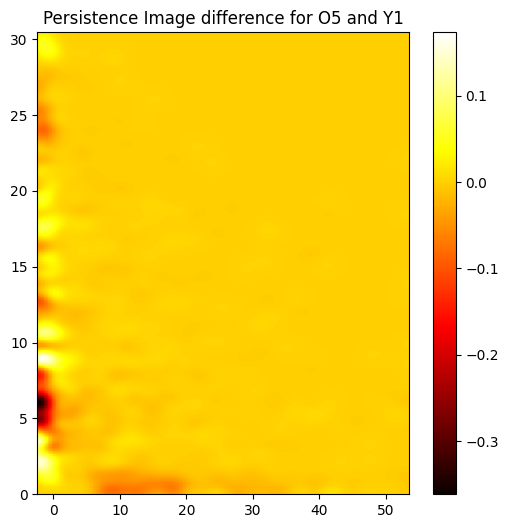

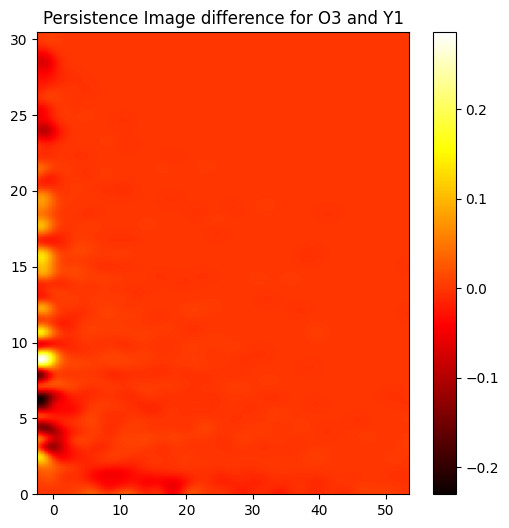

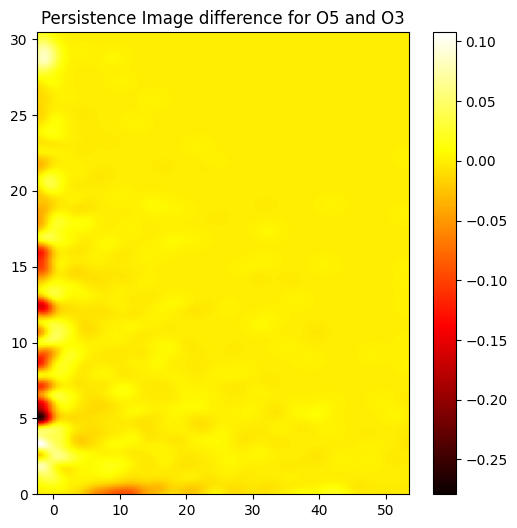

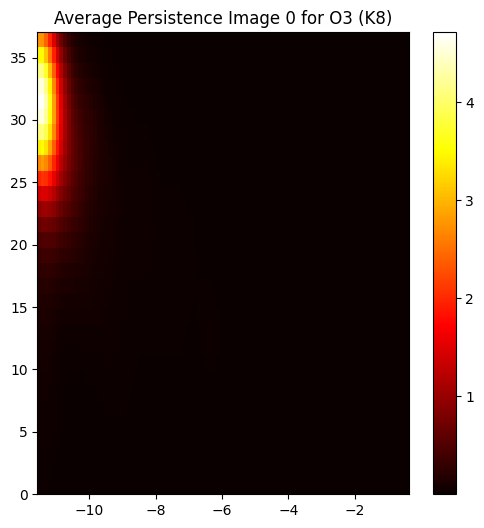

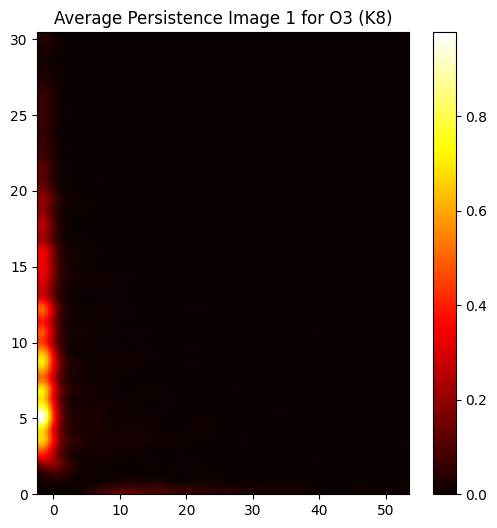

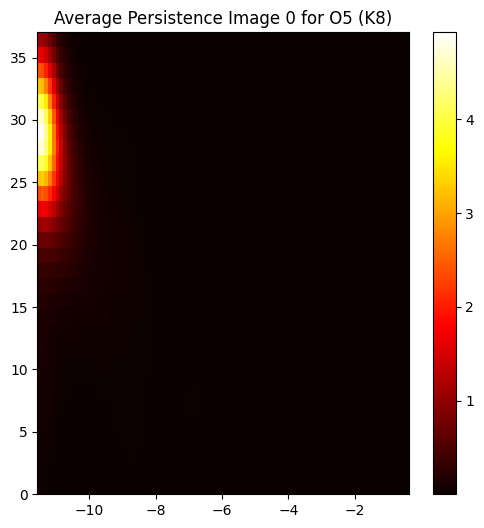

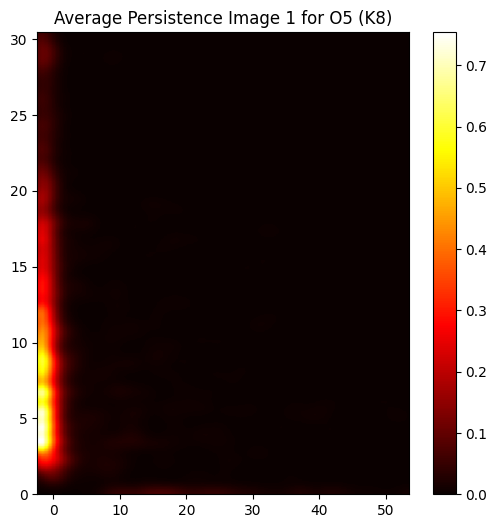

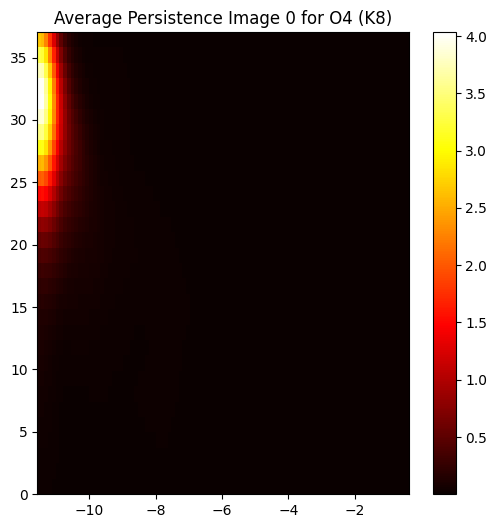

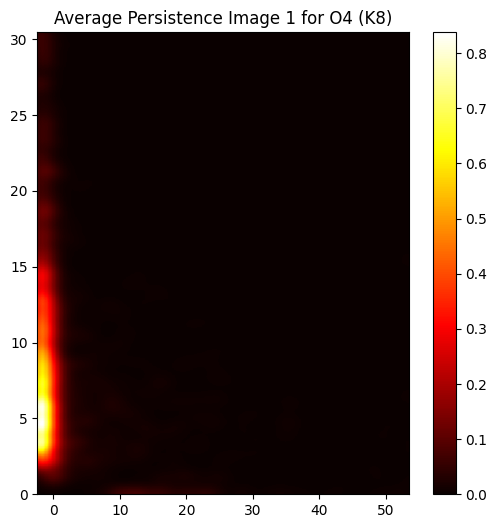

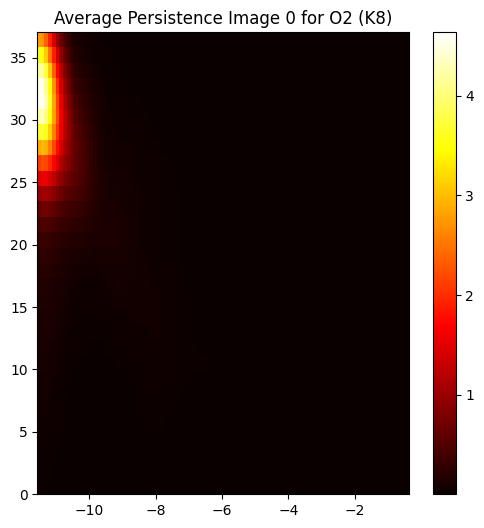

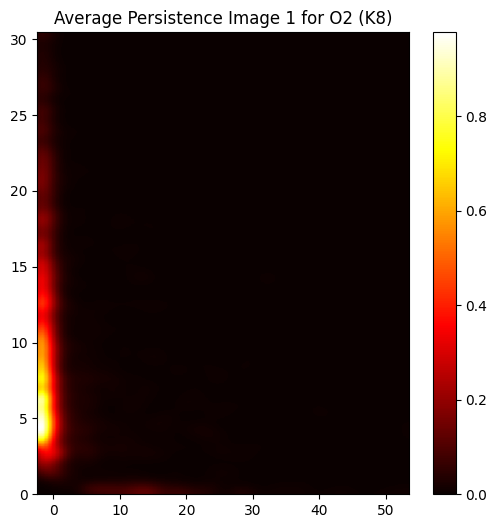

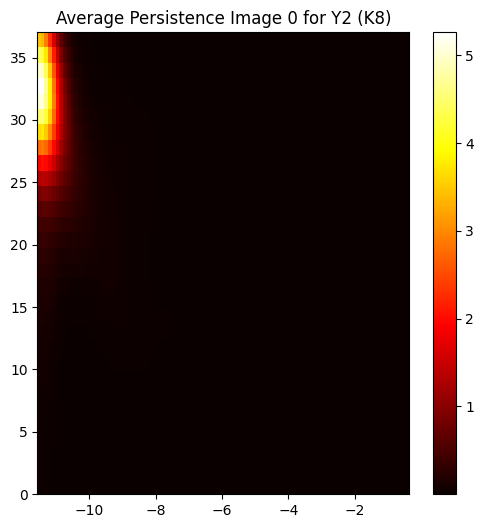

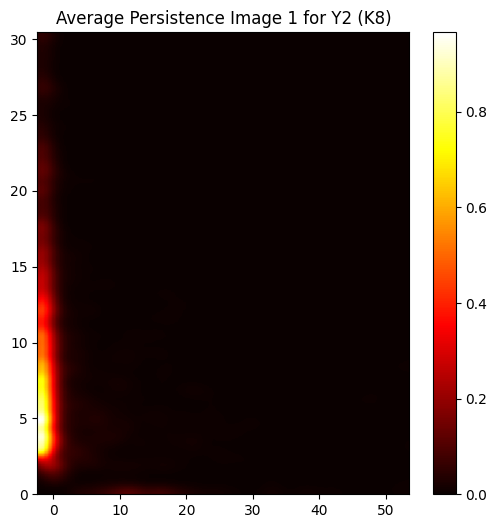

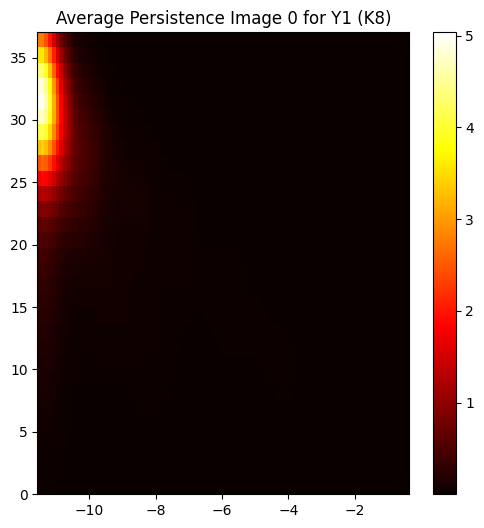

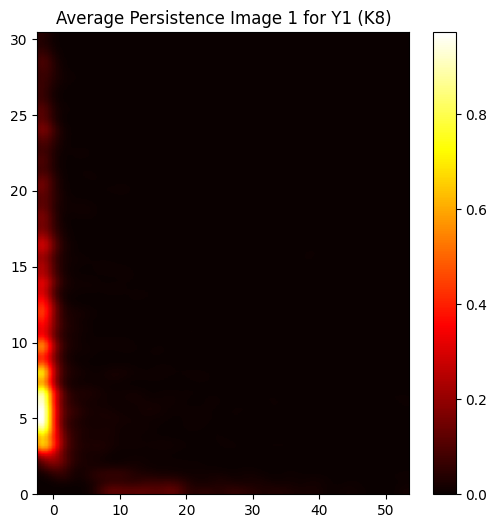

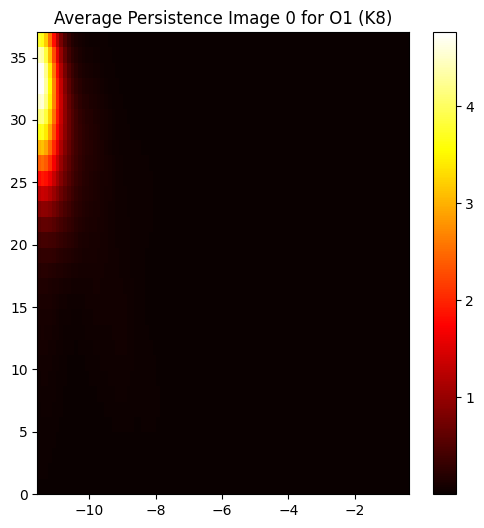

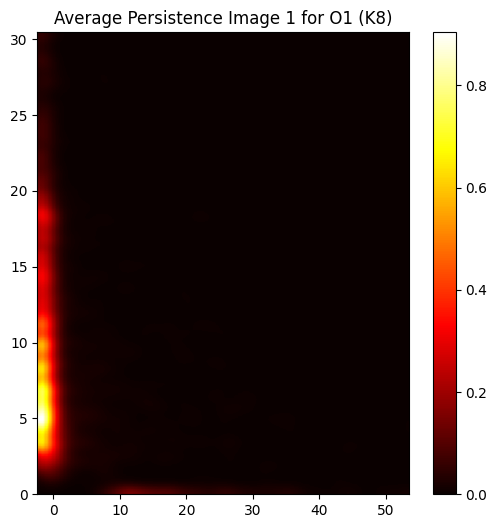

In [73]:
import os
import numpy as np
from PIL import Image
import skfmm
import matplotlib.pyplot as plt
from gudhi import CubicalComplex
from persim import PersistenceImager
from sklearn.preprocessing import MinMaxScaler
from persim.images_weights import linear_ramp

def extract_group(name):
    return name.split('_')[0]

def compute_global_ranges(diagrams):
    """Compute global birth and persistence ranges for all diagrams."""
    births = []
    persistences = []

    for dgm in diagrams:
        if len(dgm) > 0:
            births.extend(dgm[:, 0])  # Collect all birth times
            persistences.extend(dgm[:, 1] - dgm[:, 0])  # Collect all persistence values

    birth_range = (min(births), max(births)) if births else (0, 1)
    persistence_range = (min(persistences), max(persistences)) if persistences else (0, 1)

    return birth_range, persistence_range

def scale_diagram(diagram, birth_range, pers_range):
    """
    Scale persistence diagram to a consistent birth and persistence range.

    Parameters:
        diagram (ndarray): The persistence diagram to scale.
        birth_range (tuple): The target range for birth values (min, max).
        pers_range (tuple): The target range for persistence values (min, max).

    Returns:
        ndarray: The scaled persistence diagram.
    """
    if len(diagram) == 0:
        return diagram  # Return unchanged if empty

    # Separate birth and death
    births = diagram[:, 0]
    deaths = diagram[:, 1]
    persistences = deaths - births

    # Scale birth and persistence values
    scaler_birth = MinMaxScaler(feature_range=birth_range)
    scaler_pers = MinMaxScaler(feature_range=pers_range)

    scaled_births = scaler_birth.fit_transform(births.reshape(-1, 1)).flatten()
    scaled_persistences = scaler_pers.fit_transform(persistences.reshape(-1, 1)).flatten()

    # Combine back into scaled diagram
    scaled_diagram = np.column_stack([scaled_births, scaled_births + scaled_persistences])
    return scaled_diagram

def compute_betti_by_group_with_gudhi(names, datafolder):
    grouped_files = {}
    for nm in names:
        group = extract_group(nm)
        if group not in grouped_files:
            grouped_files[group] = []
        grouped_files[group].append(nm)

    # Store all diagrams for range computation
    all_diagrams_0 = []
    all_diagrams_1 = []

    for group, files in grouped_files.items():
        for nm in files:
            file_path = os.path.join(datafolder, nm)
            binary_array = (np.array(Image.open(file_path).convert('L')) < 128).astype(int)

            phi = binary_array.astype(float) - 0.5
            distance_map = skfmm.distance(phi)

            # Compute persistence using Gudhi
            cplx = CubicalComplex(top_dimensional_cells=distance_map)
            cplx.persistence()

            diagrams_0 = cplx.persistence_intervals_in_dimension(0)
            diagrams_1 = cplx.persistence_intervals_in_dimension(1)

            diagrams_0 = diagrams_0[~np.isinf(diagrams_0[:, 1])] if len(diagrams_0) > 0 else []
            diagrams_1 = diagrams_1[~np.isinf(diagrams_1[:, 1])] if len(diagrams_1) > 0 else []

            if len(diagrams_0) > 0:
                all_diagrams_0.append(diagrams_0)

            if len(diagrams_1) > 0:
                all_diagrams_1.append(diagrams_1)

    # Compute global birth and persistence ranges
    birth_range, pers_range = compute_global_ranges(all_diagrams_0)
    birth_range_1, pers_range_1 = compute_global_ranges(all_diagrams_1)

    group_results = {}
    for group, files in grouped_files.items():
        persistence_images_0 = []
        persistence_images_1 = []

        for nm in files:
            file_path = os.path.join(datafolder, nm)
            binary_array = (np.array(Image.open(file_path).convert('L')) < 128).astype(int)

            phi = binary_array.astype(float) - 0.5
            distance_map = skfmm.distance(phi)
            # plt.figure(figsize=(12, 5))

            # # Original binary image
            # plt.subplot(1, 2, 1)
            # plt.imshow(binary_array, cmap='gray')
            # plt.contour(phi, levels=[0], colors='red', linewidths=2)
            # plt.title("Original Binary Image for "  + nm)
            # plt.axis('off')

            # # Distance map from skfmm
            # plt.subplot(1, 2, 2)
            # plt.imshow(distance_map, cmap='jet')
            # plt.title("Distance Map")
            # plt.colorbar(label='Distance')
            # plt.axis('off')

            # plt.tight_layout()
            # plt.show()
            # Compute persistence using Gudhi
            cplx = CubicalComplex(top_dimensional_cells=distance_map)
            cplx.persistence()

            diagrams_0 = cplx.persistence_intervals_in_dimension(0)
            diagrams_1 = cplx.persistence_intervals_in_dimension(1)

            diagrams_0 = diagrams_0[~np.isinf(diagrams_0[:, 1])] if len(diagrams_0) > 0 else []
            diagrams_1 = diagrams_1[~np.isinf(diagrams_1[:, 1])] if len(diagrams_1) > 0 else []
        
            # Scale diagrams to consistent range
            diagrams_0 = scale_diagram(diagrams_0, birth_range, pers_range) if len(diagrams_0) > 0 else []
            diagrams_1 = scale_diagram(diagrams_1, birth_range_1, pers_range_1) if len(diagrams_1) > 0 else []

            pixel_size_pers = (pers_range[1] - pers_range[0]) / 100.0
            pixel_size_pers_1 = (pers_range_1[1] - pers_range_1[0]) / 100.0
            pimager = PersistenceImager(
                    birth_range=birth_range,
                    pers_range=pers_range,
                    pixel_size= pixel_size_pers,
                    kernel='gaussian',
                    kernel_params={'sigma': 1.0},
                    weight = linear_ramp,
                    weight_params={
                        'low': 1.0,   # Start value of weight
                        'high': 1.0,  # End value of weight, same as low -> uniform
                        'start': pers_range[0], # Start of the persistence range over which weight is applied
                        'end': pers_range[1]   # End of the persistence range
                    }
                )
            pimager1 = PersistenceImager(
                    birth_range=birth_range_1,
                    pers_range=pers_range_1,
                    pixel_size= pixel_size_pers_1,
                    kernel='gaussian',
                    kernel_params={'sigma': 0.5},
                    weight = linear_ramp,
                    weight_params={
                        'low': 1.0,   # Start value of weight
                        'high': 1.0,  # End value of weight, same as low -> uniform
                        'start': pers_range_1[0], # Start of the persistence range over which weight is applied
                        'end': pers_range_1[1]   # End of the persistence range
                    }
                )
            if len(diagrams_0) > 0:
                persistence_image_0 = pimager.transform(diagrams_0)
                persistence_images_0.append(persistence_image_0)

            if len(diagrams_1) > 0:
                persistence_image_1 = pimager1.transform(diagrams_1)
                persistence_images_1.append(persistence_image_1)

        avg_persistence_image_0 = np.mean(persistence_images_0, axis=0) if persistence_images_0 else None
        avg_persistence_image_1 = np.mean(persistence_images_1, axis=0) if persistence_images_1 else None

        group_results[group] = (avg_persistence_image_0, avg_persistence_image_1, birth_range, pers_range,birth_range_1, pers_range_1)

    return group_results

# Plot persistence images with proper extents
def plot_persistence_images(group_results, title_suffix=""):
    for group, (avg_persistence_image_0, avg_persistence_image_1, birth_range, pers_range, birth_range_1, pers_range_1) in group_results.items():
        if avg_persistence_image_0 is not None:
            plt.figure(figsize=(6, 6))
            extent = [birth_range[0], birth_range[1], pers_range[0], pers_range[1]]
            plt.imshow(avg_persistence_image_0, cmap="hot", origin="lower", extent=extent, aspect='auto')
            plt.colorbar()
            plt.title(f"Average Persistence Image 0 for {group} {title_suffix}")
            plt.show()

        if avg_persistence_image_1 is not None:
            plt.figure(figsize=(6, 6))
            extent = [birth_range_1[0], birth_range_1[1], pers_range_1[0], pers_range_1[1]]
            plt.imshow(avg_persistence_image_1, cmap="hot", origin="lower", extent=extent, aspect='auto')
            plt.colorbar()
            plt.title(f"Average Persistence Image 1 for {group} {title_suffix}")
            plt.show()


# Path to the folder containing the images
datafolder = "Old_Young_Comparison"

# Get all TIFF filenames in the folder
all_files = os.listdir(datafolder)
names = [file for file in all_files if file.lower().endswith(('.tif', '.tiff'))]

# Split names into K8 and K14 groups
names_k8 = [nm for nm in names if 'K8' in nm]
names_k14 = [nm for nm in names if 'K14' in nm]

# Compute results for K8 groups
results_k8 = compute_betti_by_group_with_gudhi(names_k8, datafolder)
pers1_O3 = results_k8['O3'][1]
pers1_O5 = results_k8['O5'][1]
pers1_Y1 = results_k8['Y1'][1]
birth_range_1 = results_k8['O3'][4]
pers_range_1 = results_k8['O3'][5]
diff1 = pers1_O5 - pers1_Y1
diff2 = pers1_O3 - pers1_Y1
diff3 = pers1_O5 - pers1_O3


plt.figure(figsize=(6, 6))
extent = [birth_range_1[0], birth_range_1[1], pers_range_1[0], pers_range_1[1]]
plt.imshow(diff1, cmap="hot", origin="lower", extent=extent, aspect='auto')
plt.colorbar()
plt.title(f"Persistence Image difference for O5 and Y1")
plt.show()

plt.figure(figsize=(6, 6))
extent = [birth_range_1[0], birth_range_1[1], pers_range_1[0], pers_range_1[1]]
plt.imshow(diff2, cmap="hot", origin="lower", extent=extent, aspect='auto')
plt.colorbar()
plt.title(f"Persistence Image difference for O3 and Y1")
plt.show()

plt.figure(figsize=(6, 6))
extent = [birth_range_1[0], birth_range_1[1], pers_range_1[0], pers_range_1[1]]
plt.imshow(diff3, cmap="hot", origin="lower", extent=extent, aspect='auto')
plt.colorbar()
plt.title(f"Persistence Image difference for O5 and O3")
plt.show()

# Compute results for K14 groups
# results_k14 = compute_betti_by_group_with_gudhi(names_k14, datafolder)

# Plot persistence images
plot_persistence_images(results_k8, title_suffix="(K8)")
# plot_persistence_images(results_k14, title_suffix="(K14)")


## K8

In [33]:
import os
import numpy as np
from PIL import Image
import skfmm
import matplotlib.pyplot as plt
from gudhi import CubicalComplex
from persim import PersistenceImager
from sklearn.preprocessing import MinMaxScaler
from persim.images_weights import linear_ramp
import random

# def colour_flipping(image, percentage, n):
#     rows, cols = image.shape
#     for i in range(n):
#         flippables = []
#           # Get the dimensions of the image
#         for i in range(1, rows - 1):  # Avoid out-of-bounds errors
#             for j in range(1, cols - 1):
#                 surrounding_entries = np.array([image[i-1,j], image[i+1,j], image[i,j-1], image[i,j+1]])
#                 if np.sum(surrounding_entries) >=2 and image[i,j] == False:
#                     flippables.append((i,j))
#         #randomly flip 10% of the flippables
#         num_flips = int(len(flippables)*percentage)
#         for i in range(num_flips):
#             flip = random.choice(flippables)
#             image[flip] = True
#     return image

def colour_flipping(image, percentage, n):
    rows, cols = image.shape
    for i in range(n):
        flippables = []
          # Get the dimensions of the image
        for i in range(1, rows - 1):  # Avoid out-of-bounds errors
            for j in range(1, cols - 1):
                surrounding_entries = np.array([image[i-1,j], image[i+1,j], image[i,j-1], image[i,j+1]])
                if np.sum(surrounding_entries) >=2 and image[i,j] == False:
                    flippables.append((i,j))
        #randomly flip 10% of the flippables
        num_flips = int(len(flippables)*percentage)
        flipped_pixels = random.sample(flippables, num_flips)  # Ensures unique flips
        for flip in flipped_pixels:
            image[flip] = not image[flip]
    for i in range(n):
        flippables = []
          # Get the dimensions of the image
        for i in range(1, rows - 1):  # Avoid out-of-bounds errors
            for j in range(1, cols - 1):
                surrounding_entries = np.array([image[i-1,j], image[i+1,j], image[i,j-1], image[i,j+1]])        
                if np.sum(surrounding_entries) ==3 and image[i,j] == True:
                    flippables.append((i,j))
        flipped_pixels = random.sample(flippables, num_flips)  # Ensures unique flips
        for flip in flipped_pixels:
            image[flip] = not image[flip]
    return image

def extract_group(name):
    return name.split('_')[0]

def compute_global_ranges(diagrams):
    """Compute global birth and persistence ranges for all diagrams."""
    births = []
    persistences = []

    for dgm in diagrams:
        if len(dgm) > 0:
            births.extend(dgm[:, 0])  # Collect all birth times
            persistences.extend(dgm[:, 1] - dgm[:, 0])  # Collect all persistence values

    birth_range = (min(births), max(births)) if births else (0, 1)
    persistence_range = (min(persistences), max(persistences)) if persistences else (0, 1)

    return birth_range, persistence_range

def scale_diagram(diagram, birth_range, pers_range):
    """
    Scale persistence diagram to a consistent birth and persistence range.

    Parameters:
        diagram (ndarray): The persistence diagram to scale.
        birth_range (tuple): The target range for birth values (min, max).
        pers_range (tuple): The target range for persistence values (min, max).

    Returns:
        ndarray: The scaled persistence diagram.
    """
    if len(diagram) == 0:
        return diagram  # Return unchanged if empty

    # Separate birth and death
    births = diagram[:, 0]
    deaths = diagram[:, 1]
    persistences = deaths - births

    # Scale birth and persistence values
    scaler_birth = MinMaxScaler(feature_range=birth_range)
    scaler_pers = MinMaxScaler(feature_range=pers_range)

    scaled_births = scaler_birth.fit_transform(births.reshape(-1, 1)).flatten()
    scaled_persistences = scaler_pers.fit_transform(persistences.reshape(-1, 1)).flatten()

    # Combine back into scaled diagram
    scaled_diagram = np.column_stack([scaled_births, scaled_births + scaled_persistences])
    return scaled_diagram

def compute_betti_by_group_with_gudhi(names, data):
    grouped_files = {}
    for nm in names:
        group = extract_group(nm)
        if group not in grouped_files:
            grouped_files[group] = []
        grouped_files[group].append(nm)

    # Store all diagrams for range computation
    all_diagrams_0 = []
    all_diagrams_1 = []

    for group, files in grouped_files.items():
        for nm in files:
            file_path = os.path.join(datafolder, nm)
            binary_array = data[nm]

            phi = binary_array.astype(float) - 0.5
            distance_map = skfmm.distance(phi)

            # Compute persistence using Gudhi
            cplx = CubicalComplex(top_dimensional_cells=distance_map)
            cplx.persistence()

            diagrams_0 = cplx.persistence_intervals_in_dimension(0)
            diagrams_1 = cplx.persistence_intervals_in_dimension(1)

            diagrams_0 = diagrams_0[~np.isinf(diagrams_0[:, 1])] if len(diagrams_0) > 0 else []
            diagrams_1 = diagrams_1[~np.isinf(diagrams_1[:, 1])] if len(diagrams_1) > 0 else []

            if len(diagrams_0) > 0:
                all_diagrams_0.append(diagrams_0)

            if len(diagrams_1) > 0:
                all_diagrams_1.append(diagrams_1)

    # Compute global birth and persistence ranges
    birth_range, pers_range = compute_global_ranges(all_diagrams_0)
    birth_range_1, pers_range_1 = compute_global_ranges(all_diagrams_1)

    group_results = {}
    for group, files in grouped_files.items():

        for nm in files:
            file_path = os.path.join(datafolder, nm)
            binary_array = (np.array(Image.open(file_path).convert('L')) < 128).astype(int)

            phi = binary_array.astype(float) - 0.5
            distance_map = skfmm.distance(phi)
            # plt.figure(figsize=(12, 5))

            # # Original binary image
            # plt.subplot(1, 2, 1)
            # plt.imshow(binary_array, cmap='gray')
            # plt.contour(phi, levels=[0], colors='red', linewidths=2)
            # plt.title("Original Binary Image for "  + nm)
            # plt.axis('off')

            # # Distance map from skfmm
            # plt.subplot(1, 2, 2)
            # plt.imshow(distance_map, cmap='jet')
            # plt.title("Distance Map")
            # plt.colorbar(label='Distance')
            # plt.axis('off')

            # plt.tight_layout()
            # plt.show()
            # Compute persistence using Gudhi
            cplx = CubicalComplex(top_dimensional_cells=distance_map)
            cplx.persistence()

            diagrams_0 = cplx.persistence_intervals_in_dimension(0)
            diagrams_1 = cplx.persistence_intervals_in_dimension(1)

            diagrams_0 = diagrams_0[~np.isinf(diagrams_0[:, 1])] if len(diagrams_0) > 0 else []
            diagrams_1 = diagrams_1[~np.isinf(diagrams_1[:, 1])] if len(diagrams_1) > 0 else []
        
            # Scale diagrams to consistent range
            diagrams_0 = scale_diagram(diagrams_0, birth_range, pers_range) if len(diagrams_0) > 0 else []
            diagrams_1 = scale_diagram(diagrams_1, birth_range_1, pers_range_1) if len(diagrams_1) > 0 else []

            pixel_size_pers = (pers_range[1] - pers_range[0]) / 500.0
            pixel_size_pers_1 = (pers_range_1[1] - pers_range_1[0]) / 500.0
            pimager = PersistenceImager(
                    birth_range=birth_range,
                    pers_range=pers_range,
                    pixel_size= pixel_size_pers,
                    kernel='gaussian',
                    kernel_params={'sigma': 1.0},
                    weight = linear_ramp,
                    weight_params={
                        'low': 1.0,   # Start value of weight
                        'high': 1.0,  # End value of weight, same as low -> uniform
                        'start': pers_range[0], # Start of the persistence range over which weight is applied
                        'end': pers_range[1]   # End of the persistence range
                    }
                )
            pimager1 = PersistenceImager(
                    birth_range=birth_range_1,
                    pers_range=pers_range_1,
                    pixel_size= pixel_size_pers_1,
                    kernel='gaussian',
                    kernel_params={'sigma': 1.0},
                    weight = linear_ramp,
                    weight_params={
                        'low': 1.0,   # Start value of weight
                        'high': 1.0,  # End value of weight, same as low -> uniform
                        'start': pers_range_1[0], # Start of the persistence range over which weight is applied
                        'end': pers_range_1[1]   # End of the persistence range
                    }
                )
            if len(diagrams_0) > 0:
                persistence_image_0 = pimager.transform(diagrams_0)

            if len(diagrams_1) > 0:
                persistence_image_1 = pimager1.transform(diagrams_1)
            group_results[nm] = (persistence_image_0, persistence_image_1, birth_range, pers_range,birth_range_1, pers_range_1)
    return group_results


def compute_ect(names, datafolder):
    data = {}
    for nm in names:
        file_path = os.path.join(datafolder, nm)
        img_array = np.array(Image.open(file_path))
        # img_array = colour_flipping(img_array, 0.5, 5)
        data[nm] = img_array
    return data


datafolder = "Old_Young_Comparison"
data_k8 = compute_ect(names_k8, datafolder)

# Path to the folder containing the images


# Get all TIFF filenames in the folder
all_files = os.listdir(datafolder)
names = [file for file in all_files if file.lower().endswith(('.tif', '.tiff'))]

# Split names into K8 and K14 groups
names_k8 = [nm for nm in names if 'K8' in nm]
names_k14 = [nm for nm in names if 'K14' in nm]

# Compute results for K8 groups
results_k8 = compute_betti_by_group_with_gudhi(names_k8, data_k8)
flattened_k8 = [
    np.concatenate((results_k8[nm][0].flatten(), results_k8[nm][1].flatten()))
    for nm in names_k8
]


In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
import matplotlib.pyplot as plt

def extract_age(name):
    return name[0]

ages_k8 = [extract_age(name) for name in names_k8]
X = np.array(flattened_k8)
y = np.array(ages_k8)
unique_ages = np.unique(y)
ypoints, xpoints = 110, 300  # Set the appropriate image dimensions

# Number of trials for train-test splitting
num_trials = 50
age = unique_ages[0]
print(f"Processing age group: {age}")

# Binary classification: 1 if the sample belongs to the current age, 0 otherwise
binary_labels = np.where(y == age, 1, 0)

scores = []

# Parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200,500,1000],       # Number of trees in the forest
    'max_depth': [3, 5, 7, None],         # Tree depth (None means no limit)
    'min_samples_split': [2, 5, 10],      # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],        # Minimum samples at a leaf node
}

# Perform Grid Search
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=40),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1
)
grid_search.fit(X, binary_labels)

# Best parameters
best_params = grid_search.best_params_
print(f"Best parameters for age group {age}: {best_params}")


Processing age group: O
Best parameters for age group O: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [35]:
def extract_age(name):
    return name[0]

ages_k8 = [extract_age(name) for name in names_k8]
X = np.array(flattened_k8)
y = np.array(ages_k8)
unique_ages = np.unique(y)
ypoints, xpoints = 110, 300  # Set the appropriate image dimensions

# Number of trials for train-test splitting
num_trials = 50
age = unique_ages[0]
print(f"Processing age group: {age}")

# Binary classification: 1 if the sample belongs to the current age, 0 otherwise
binary_labels = np.where(y == age, 1, 0)
num_true = np.sum(binary_labels)
# Prepare variables to store SHAP values for averaging
shap_values_aggregate_1 = None  # To store the sum of SHAP values for class 1 across trials
shap_values_aggregate_0 = None  # To store the sum of SHAP values for class 0 across trials
n_1 = 0  # Counter for trials where samples are classified as 1
n_0 = 0  # Counter for trials where samples are classified as 0
scores = []
# Loop for multiple random splits
for trial in range(num_trials):
    # print(f"Trial {trial + 1}/{num_trials}")

    # Step 2: Randomize train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, binary_labels, test_size=0.2, random_state=40+trial)

    # Step 3: Initialize and train the Random Forest classifier
    rf_classifier = RandomForestClassifier(max_depth = 5,min_samples_leaf=1, min_samples_split=2, n_estimators=50,random_state=40)
    rf_classifier.fit(X_train, y_train)
    score = rf_classifier.score(X_test, y_test)
    scores.append(score)
    
print(f'average accuracy for age {age} is {np.mean(scores)}')

Processing age group: O
average accuracy for age O is 0.6585714285714286


## K14

In [30]:
import os
import numpy as np
from PIL import Image
import skfmm
import matplotlib.pyplot as plt
from gudhi import CubicalComplex
from persim import PersistenceImager
from sklearn.preprocessing import MinMaxScaler
from persim.images_weights import linear_ramp
import random

# def colour_flipping(image, percentage, n):
#     rows, cols = image.shape
#     for i in range(n):
#         flippables = []
#           # Get the dimensions of the image
#         for i in range(1, rows - 1):  # Avoid out-of-bounds errors
#             for j in range(1, cols - 1):
#                 surrounding_entries = np.array([image[i-1,j], image[i+1,j], image[i,j-1], image[i,j+1]])
#                 if np.sum(surrounding_entries) >=2 and image[i,j] == False:
#                     flippables.append((i,j))
#         #randomly flip 10% of the flippables
#         num_flips = int(len(flippables)*percentage)
#         for i in range(num_flips):
#             flip = random.choice(flippables)
#             image[flip] = True
#     return image

def colour_flipping(image, percentage, n):
    rows, cols = image.shape
    for i in range(n):
        flippables = []
          # Get the dimensions of the image
        for i in range(1, rows - 1):  # Avoid out-of-bounds errors
            for j in range(1, cols - 1):
                surrounding_entries = np.array([image[i-1,j], image[i+1,j], image[i,j-1], image[i,j+1]])
                if np.sum(surrounding_entries) >=2 and image[i,j] == False:
                    flippables.append((i,j))
        #randomly flip 10% of the flippables
        num_flips = int(len(flippables)*percentage)
        flipped_pixels = random.sample(flippables, num_flips)  # Ensures unique flips
        for flip in flipped_pixels:
            image[flip] = not image[flip]
    for i in range(n):
        flippables = []
          # Get the dimensions of the image
        for i in range(1, rows - 1):  # Avoid out-of-bounds errors
            for j in range(1, cols - 1):
                surrounding_entries = np.array([image[i-1,j], image[i+1,j], image[i,j-1], image[i,j+1]])        
                if np.sum(surrounding_entries) ==3 and image[i,j] == True:
                    flippables.append((i,j))
        flipped_pixels = random.sample(flippables, num_flips)  # Ensures unique flips
        for flip in flipped_pixels:
            image[flip] = not image[flip]
    return image

def extract_group(name):
    return name.split('_')[0]

def compute_global_ranges(diagrams):
    """Compute global birth and persistence ranges for all diagrams."""
    births = []
    persistences = []

    for dgm in diagrams:
        if len(dgm) > 0:
            births.extend(dgm[:, 0])  # Collect all birth times
            persistences.extend(dgm[:, 1] - dgm[:, 0])  # Collect all persistence values

    birth_range = (min(births), max(births)) if births else (0, 1)
    persistence_range = (min(persistences), max(persistences)) if persistences else (0, 1)

    return birth_range, persistence_range

def scale_diagram(diagram, birth_range, pers_range):
    """
    Scale persistence diagram to a consistent birth and persistence range.

    Parameters:
        diagram (ndarray): The persistence diagram to scale.
        birth_range (tuple): The target range for birth values (min, max).
        pers_range (tuple): The target range for persistence values (min, max).

    Returns:
        ndarray: The scaled persistence diagram.
    """
    if len(diagram) == 0:
        return diagram  # Return unchanged if empty

    # Separate birth and death
    births = diagram[:, 0]
    deaths = diagram[:, 1]
    persistences = deaths - births

    # Scale birth and persistence values
    scaler_birth = MinMaxScaler(feature_range=birth_range)
    scaler_pers = MinMaxScaler(feature_range=pers_range)

    scaled_births = scaler_birth.fit_transform(births.reshape(-1, 1)).flatten()
    scaled_persistences = scaler_pers.fit_transform(persistences.reshape(-1, 1)).flatten()

    # Combine back into scaled diagram
    scaled_diagram = np.column_stack([scaled_births, scaled_births + scaled_persistences])
    return scaled_diagram

def compute_betti_by_group_with_gudhi(names, data):
    grouped_files = {}
    for nm in names:
        group = extract_group(nm)
        if group not in grouped_files:
            grouped_files[group] = []
        grouped_files[group].append(nm)

    # Store all diagrams for range computation
    all_diagrams_0 = []
    all_diagrams_1 = []

    for group, files in grouped_files.items():
        for nm in files:
            file_path = os.path.join(datafolder, nm)
            binary_array = data[nm]

            phi = binary_array.astype(float) - 0.5
            distance_map = skfmm.distance(phi)

            # Compute persistence using Gudhi
            cplx = CubicalComplex(top_dimensional_cells=distance_map)
            cplx.persistence()

            diagrams_0 = cplx.persistence_intervals_in_dimension(0)
            diagrams_1 = cplx.persistence_intervals_in_dimension(1)

            diagrams_0 = diagrams_0[~np.isinf(diagrams_0[:, 1])] if len(diagrams_0) > 0 else []
            diagrams_1 = diagrams_1[~np.isinf(diagrams_1[:, 1])] if len(diagrams_1) > 0 else []

            if len(diagrams_0) > 0:
                all_diagrams_0.append(diagrams_0)

            if len(diagrams_1) > 0:
                all_diagrams_1.append(diagrams_1)

    # Compute global birth and persistence ranges
    birth_range, pers_range = compute_global_ranges(all_diagrams_0)
    birth_range_1, pers_range_1 = compute_global_ranges(all_diagrams_1)

    group_results = {}
    for group, files in grouped_files.items():

        for nm in files:
            file_path = os.path.join(datafolder, nm)
            binary_array = (np.array(Image.open(file_path).convert('L')) < 128).astype(int)

            phi = binary_array.astype(float) - 0.5
            distance_map = skfmm.distance(phi)
            # plt.figure(figsize=(12, 5))

            # # Original binary image
            # plt.subplot(1, 2, 1)
            # plt.imshow(binary_array, cmap='gray')
            # plt.contour(phi, levels=[0], colors='red', linewidths=2)
            # plt.title("Original Binary Image for "  + nm)
            # plt.axis('off')

            # # Distance map from skfmm
            # plt.subplot(1, 2, 2)
            # plt.imshow(distance_map, cmap='jet')
            # plt.title("Distance Map")
            # plt.colorbar(label='Distance')
            # plt.axis('off')

            # plt.tight_layout()
            # plt.show()
            # Compute persistence using Gudhi
            cplx = CubicalComplex(top_dimensional_cells=distance_map)
            cplx.persistence()

            diagrams_0 = cplx.persistence_intervals_in_dimension(0)
            diagrams_1 = cplx.persistence_intervals_in_dimension(1)

            diagrams_0 = diagrams_0[~np.isinf(diagrams_0[:, 1])] if len(diagrams_0) > 0 else []
            diagrams_1 = diagrams_1[~np.isinf(diagrams_1[:, 1])] if len(diagrams_1) > 0 else []
        
            # Scale diagrams to consistent range
            diagrams_0 = scale_diagram(diagrams_0, birth_range, pers_range) if len(diagrams_0) > 0 else []
            diagrams_1 = scale_diagram(diagrams_1, birth_range_1, pers_range_1) if len(diagrams_1) > 0 else []

            pixel_size_pers = (pers_range[1] - pers_range[0]) / 500.0
            pixel_size_pers_1 = (pers_range_1[1] - pers_range_1[0]) / 500.0
            pimager = PersistenceImager(
                    birth_range=birth_range,
                    pers_range=pers_range,
                    pixel_size= pixel_size_pers,
                    kernel='gaussian',
                    kernel_params={'sigma': 1.0},
                    weight = linear_ramp,
                    weight_params={
                        'low': 1.0,   # Start value of weight
                        'high': 1.0,  # End value of weight, same as low -> uniform
                        'start': pers_range[0], # Start of the persistence range over which weight is applied
                        'end': pers_range[1]   # End of the persistence range
                    }
                )
            pimager1 = PersistenceImager(
                    birth_range=birth_range_1,
                    pers_range=pers_range_1,
                    pixel_size= pixel_size_pers_1,
                    kernel='gaussian',
                    kernel_params={'sigma': 1.0},
                    weight = linear_ramp,
                    weight_params={
                        'low': 1.0,   # Start value of weight
                        'high': 1.0,  # End value of weight, same as low -> uniform
                        'start': pers_range_1[0], # Start of the persistence range over which weight is applied
                        'end': pers_range_1[1]   # End of the persistence range
                    }
                )
            if len(diagrams_0) > 0:
                persistence_image_0 = pimager.transform(diagrams_0)

            if len(diagrams_1) > 0:
                persistence_image_1 = pimager1.transform(diagrams_1)
            group_results[nm] = (persistence_image_0, persistence_image_1, birth_range, pers_range,birth_range_1, pers_range_1)
    return group_results


def compute_ect(names, datafolder):
    data = {}
    for nm in names:
        file_path = os.path.join(datafolder, nm)
        img_array = np.array(Image.open(file_path))
        # img_array = colour_flipping(img_array, 0.5, 5)
        data[nm] = img_array
    return data


datafolder = "Old_Young_Comparison"
data_k14 = compute_ect(names_k14, datafolder)

# Path to the folder containing the images


# Get all TIFF filenames in the folder
all_files = os.listdir(datafolder)
names = [file for file in all_files if file.lower().endswith(('.tif', '.tiff'))]

# Split names into K8 and K14 groups
names_k8 = [nm for nm in names if 'K8' in nm]
names_k14 = [nm for nm in names if 'K14' in nm]

# Compute results for K8 groups
results_k14 = compute_betti_by_group_with_gudhi(names_k14, data_k14)
flattened_k14 = [
    np.concatenate((results_k14[nm][0].flatten(), results_k14[nm][1].flatten()))
    for nm in names_k14
]


In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
import matplotlib.pyplot as plt

def extract_age(name):
    return name[0]

ages_k14 = [extract_age(name) for name in names_k14]
X = np.array(flattened_k14)
y = np.array(ages_k14)
unique_ages = np.unique(y)
ypoints, xpoints = 110, 300  # Set the appropriate image dimensions

# Number of trials for train-test splitting
num_trials = 50
age = unique_ages[0]
print(f"Processing age group: {age}")

# Binary classification: 1 if the sample belongs to the current age, 0 otherwise
binary_labels = np.where(y == age, 1, 0)

scores = []

# Parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200,500,1000],       # Number of trees in the forest
    'max_depth': [3, 5, 7, None],         # Tree depth (None means no limit)
    'min_samples_split': [2, 5, 10],      # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],        # Minimum samples at a leaf node
}

# Perform Grid Search
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=40),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1
)
grid_search.fit(X, binary_labels)

# Best parameters
best_params = grid_search.best_params_
print(f"Best parameters for age group {age}: {best_params}")


Processing age group: O


/Users/hyang/.pyenv/versions/3.10.12/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for age group O: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


In [32]:
def extract_age(name):
    return name[0]

ages_k14 = [extract_age(name) for name in names_k8]
X = np.array(flattened_k14)
y = np.array(ages_k14)
unique_ages = np.unique(y)
ypoints, xpoints = 110, 300  # Set the appropriate image dimensions

# Number of trials for train-test splitting
num_trials = 50
age = unique_ages[0]
print(f"Processing age group: {age}")

# Binary classification: 1 if the sample belongs to the current age, 0 otherwise
binary_labels = np.where(y == age, 1, 0)
num_true = np.sum(binary_labels)
print(f"Number of samples in age group {age}: {num_true}")
# Prepare variables to store SHAP values for averaging
shap_values_aggregate_1 = None  # To store the sum of SHAP values for class 1 across trials
shap_values_aggregate_0 = None  # To store the sum of SHAP values for class 0 across trials
n_1 = 0  # Counter for trials where samples are classified as 1
n_0 = 0  # Counter for trials where samples are classified as 0
scores = []
# Loop for multiple random splits
for trial in range(num_trials):
    # print(f"Trial {trial + 1}/{num_trials}")

    # Step 2: Randomize train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, binary_labels, test_size=0.2, random_state=40+trial)

    # Step 3: Initialize and train the Random Forest classifier
    rf_classifier = RandomForestClassifier(max_depth = 3,max_features = 'sqrt',min_samples_leaf=2, min_samples_split=10, n_estimators=100,random_state=40)
    rf_classifier.fit(X_train, y_train)
    score = rf_classifier.score(X_test, y_test)
    scores.append(score)
    
print(f'average accuracy for age {age} is {np.mean(scores)}')

Processing age group: O
Number of samples in age group O: 50
average accuracy for age O is 0.6985714285714286
